In [1]:
from datetime import datetime
from getpass import getpass
import random

rdm_url = 'https://staging.rdm.nii.ac.jp/'
idp_name_1 = "GakuNin RDM IdP"
idp_username_1 = "ierae08"
idp_password_1 = "YibkH0U9-3^%Z@v8"
rdm_project_name = 'TEST-WikiHierarchy-{}'.format(datetime.now().strftime('%Y%m%d'))
target_storage_name = 'NII Storage'
target_storage_id = 'osfstorage'
delete_project = True
default_result_path = None
close_on_fail = False
transition_timeout = 60000

In [3]:
if idp_username_1 is None:
    idp_username_1 = input(prompt=f'Username for {idp_name_1}')
if idp_password_1 is None:
    idp_password_1 = getpass(prompt=f'Password for {idp_username_1}@{idp_name_1}')
(len(idp_username_1), len(idp_password_1))

(7, 16)

In [4]:
import tempfile

work_dir = tempfile.mkdtemp()
if default_result_path is None:
    default_result_path = work_dir
work_dir

'/tmp/tmpdsl90wou'

# WikiHierarchy

- サブシステム名: アドオン
- ページ/アドオン: WikiHierarchy
- 機能分類: Wiki操作
- シナリオ名: WikiHierarchy
- 用意するテストデータ: URL一覧、アカウント(既存ユーザー1: GRDM)

In [5]:
import importlib
import pandas as pd

import scripts.playwright
importlib.reload(scripts.playwright)

from scripts.playwright import *
from scripts import grdm

await init_pw_context(close_on_fail=False, last_path=default_result_path)

('20260106-083059', '/tmp/tmpcyvvflry')

## ダッシュボードのURLを開く

GRDMダッシュボードが表示されること

Start epoch: 1767688260.1122072 seconds


ierae08
YibkH0U9-3^%Z@v8


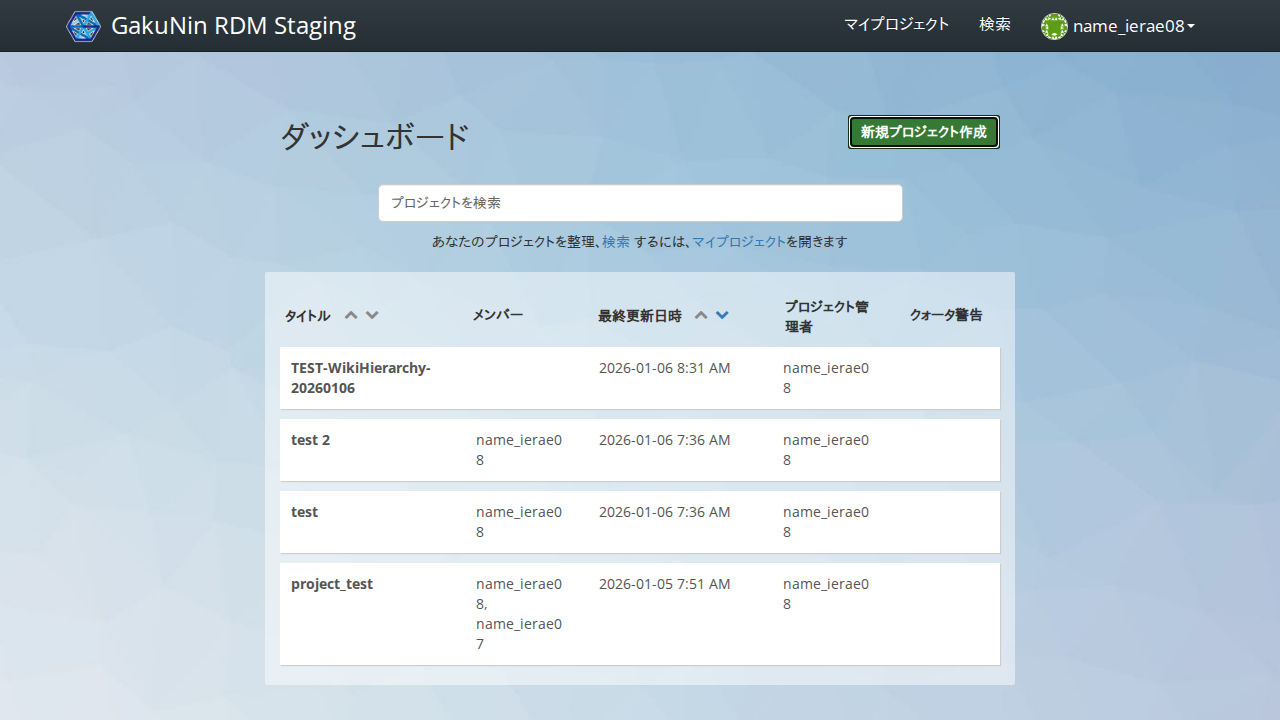

In [6]:
import scripts.grdm
importlib.reload(scripts.grdm)

async def _step(page):
    await page.goto(rdm_url)

    # 同意する をクリック
    await page.locator('//button[text() = "同意する"]').click()

    # 同意する が表示されなくなったことを確認
    await expect(page.locator('//button[text() = "同意する"]')).to_have_count(0, timeout=500)
    await scripts.grdm.login(
        page, idp_name_1, idp_username_1, idp_password_1, transition_timeout=transition_timeout
    )

    # GRDMのボタンが表示されることを確認
    await expect(page.locator('//*[text() = "プロジェクト管理者"]')).to_be_visible(timeout=transition_timeout)
    await scripts.grdm.ensure_project_exists(page, rdm_project_name, transition_timeout=transition_timeout)

await run_pw(_step)

## 対象のプロジェクトをクリックする

プロジェクトが表示されること

Start epoch: 1767688278.2989702 seconds


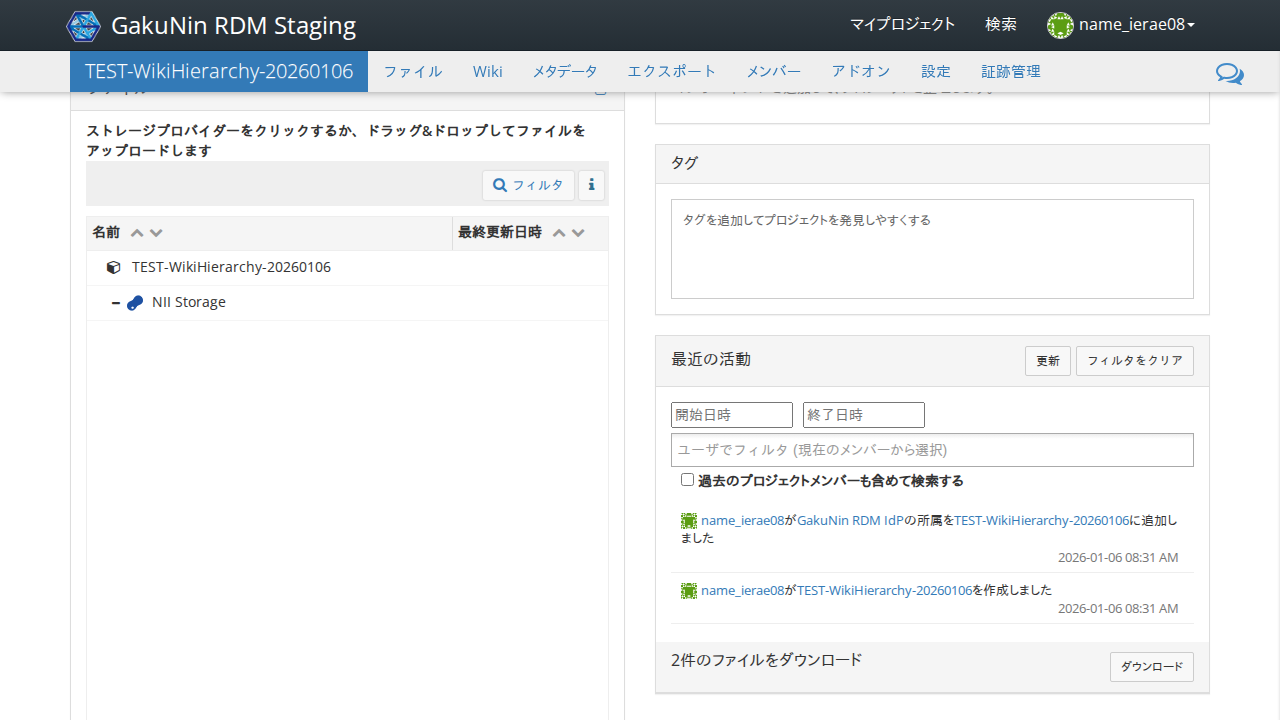

In [7]:
async def _step(page):
    await page.locator(f'//*[@data-test-dashboard-item-title and text()="{rdm_project_name}"]').click()        

    await expect(page.locator('//a[text() = "アドオン"]')).to_be_visible(timeout=transition_timeout)
    await expect(grdm.get_select_expanded_storage_title_locator(page, target_storage_name)).to_be_visible(timeout=transition_timeout)
    time.sleep(1)

    await page.locator('//h3[text()="最近の活動"]').click()

await run_pw(_step)

## ファイルタブをクリックする

画面がファイルに切り替わること

Start epoch: 1767688281.8666143 seconds


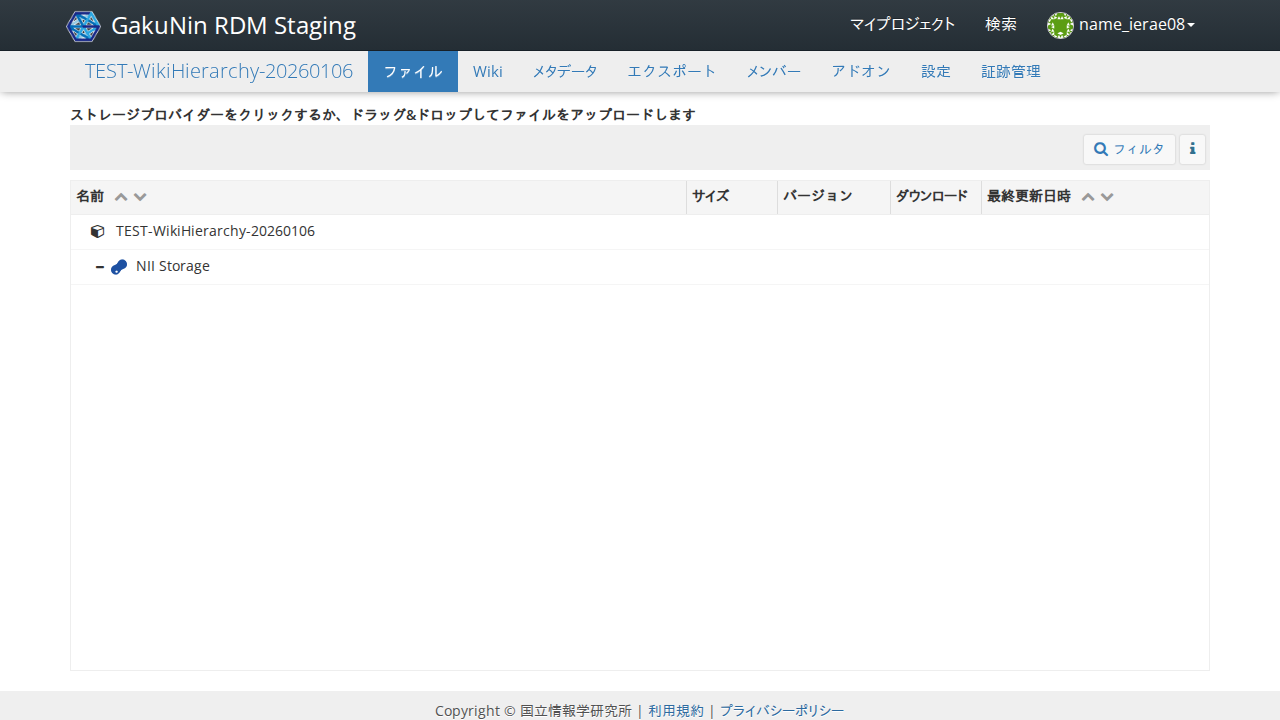

In [8]:
async def _step(page):
    await page.locator('#projectNavFiles a').click()
    time.sleep(1)
    await expect(page.locator('//a[text() = "アドオン"]')).to_be_visible(timeout=transition_timeout)
    await expect(grdm.get_select_expanded_storage_title_locator(page, target_storage_name)).to_be_visible(timeout=transition_timeout)
    time.sleep(1)

    await expect(page.locator('//h3[text()="最近の活動"]')).not_to_be_visible()

await run_pw(_step)

## 「NII Storage」を選択し、画面上部の「フォルダのアップロード」ボタンをクリックする

フォルダ選択画面が表示される

Start epoch: 1767688285.5684144 seconds


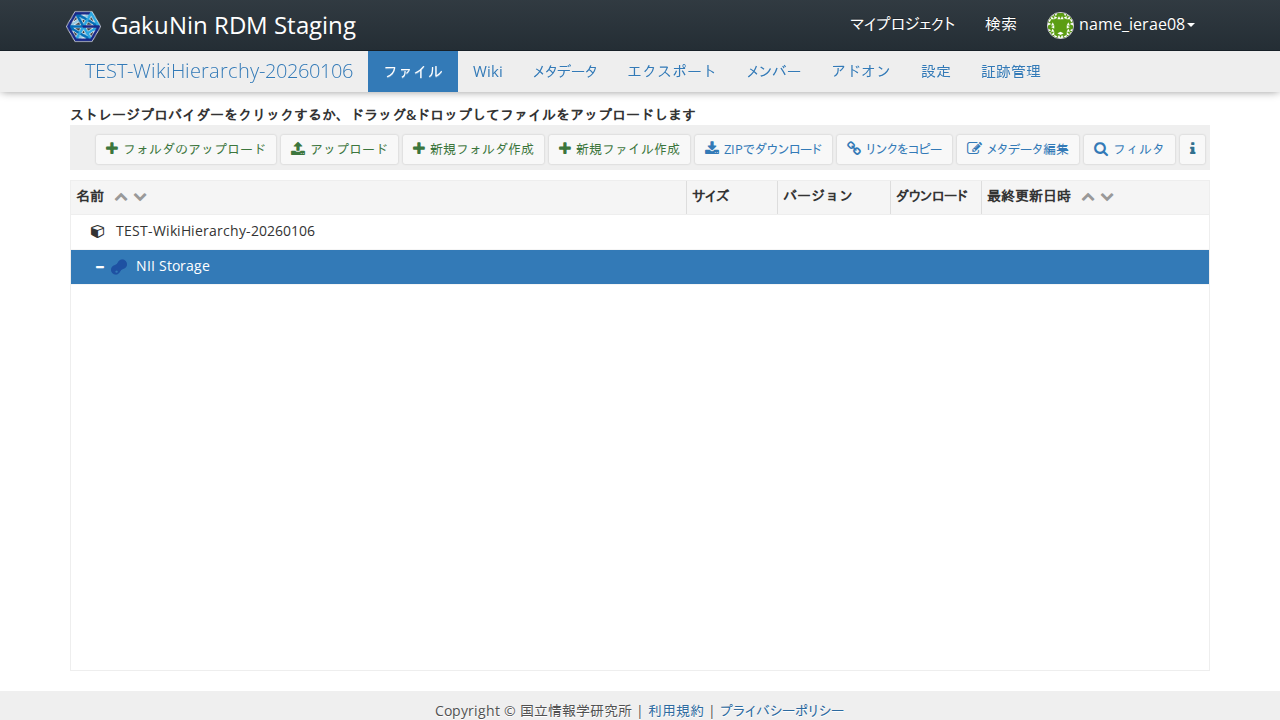

In [9]:
async def _step(page):
    await grdm.get_select_storage_title_locator(page, target_storage_name).click()
    await expect(page.locator('//i[contains(@class, "fa-plus")]/../*[text() = "フォルダのアップロード"]')).to_be_enabled()

await run_pw(_step)

## 事前に用意しておいた「WikiImport_Hierarchy」フォルダを選択し「アップロード」ボタンをクリックする

ファイルのアップロード確認メッセージが表示される

Start epoch: 1767688285.9243371 seconds


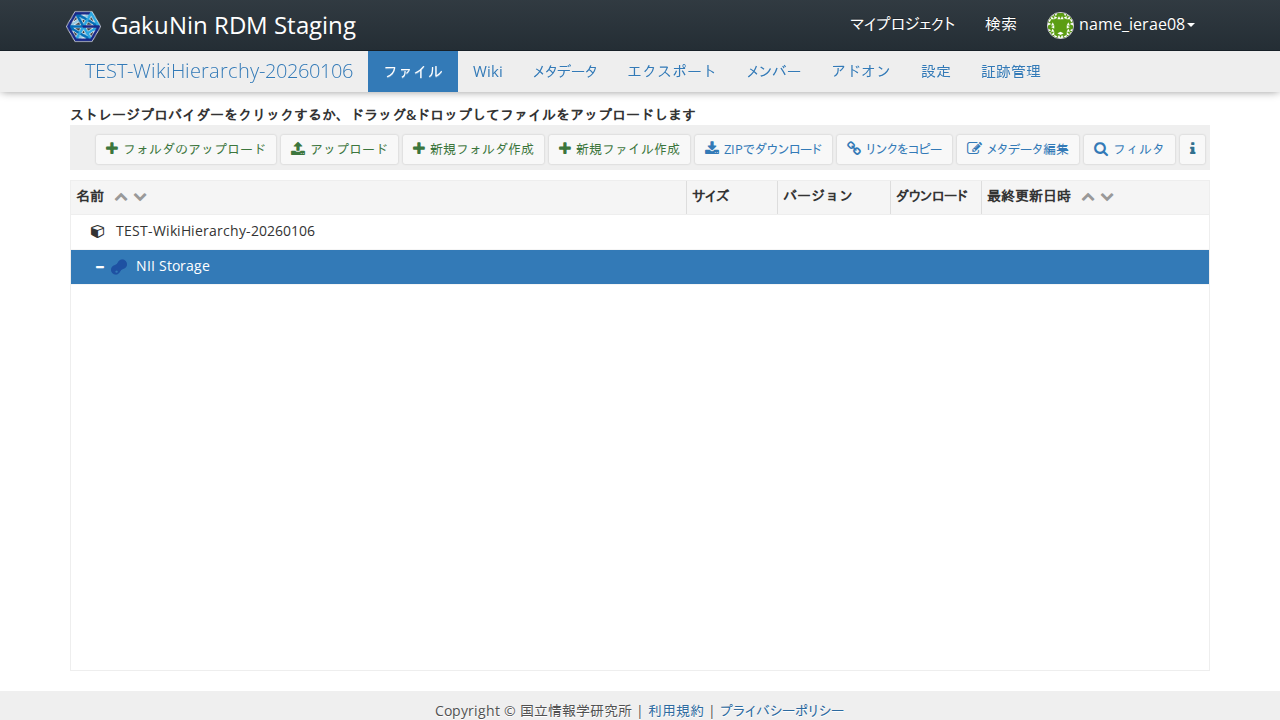

In [10]:
# ・(補足)自動試験の場合、「確認内容」が確認できないため、手動で作業が必要
async def _step(page):
    pass

await run_pw(_step)

## 事前に用意しておいた「WikiImport_Hierarchy」フォルダを選択し「アップロード」ボタンをクリックする

ファイルのアップロード確認メッセージが表示される

Start epoch: 1767688286.2283018 seconds


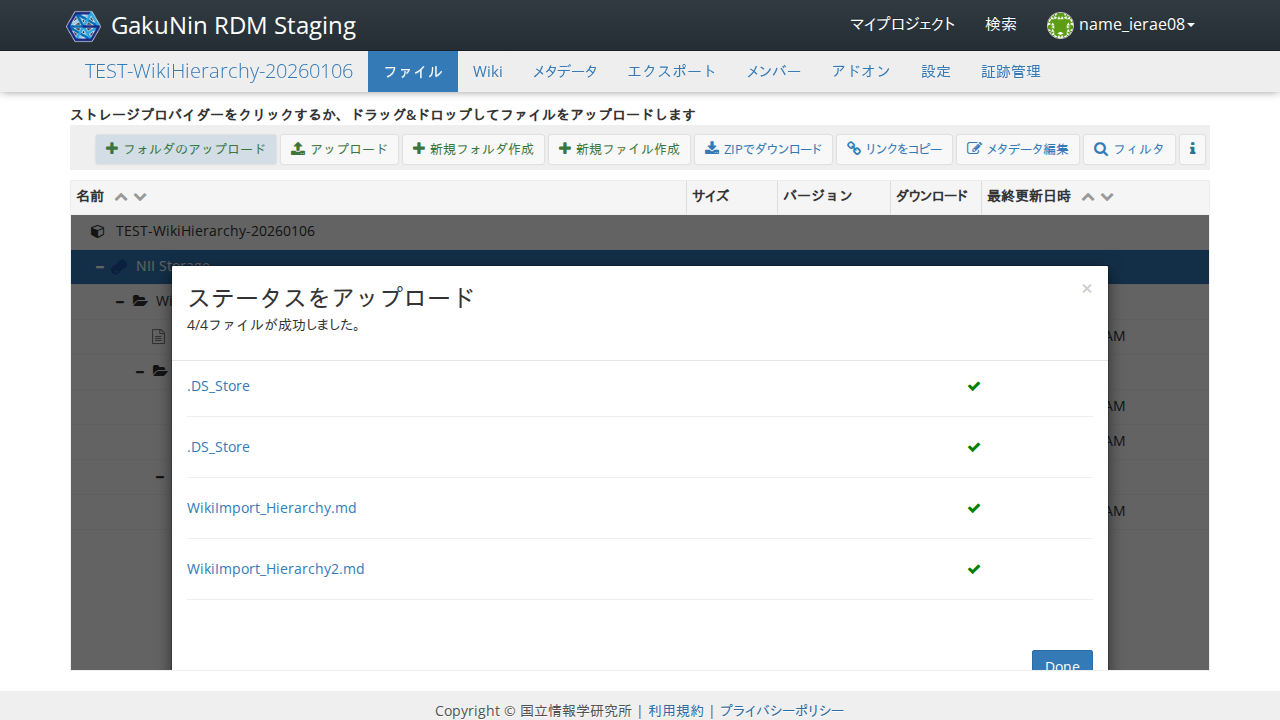

In [11]:
foldername = 'WikiImport_Hierarchy'
folderpath = os.path.join('resources/Datatest-Wiki', foldername)

async def _step(page):
    await grdm.upload_folder(page, folderpath)
    await expect(page.locator('text="ステータスをアップロード"')).to_be_visible(timeout=transition_timeout)
    filecount = sum(len(files) for _, _, files in os.walk(folderpath))
    await expect(page.locator(f'text="{filecount}/{filecount}ファイルが成功しました。"')).to_be_visible(timeout=transition_timeout)
    await expect(page.locator('//a[text() = "Done"]')).to_be_enabled(timeout=transition_timeout)

await run_pw(_step)

## 「ステータスをアップロード」画面下の「Done」ボタンをクリックする

「ステータスをアップロード」画面が消える

Start epoch: 1767688296.6962278 seconds


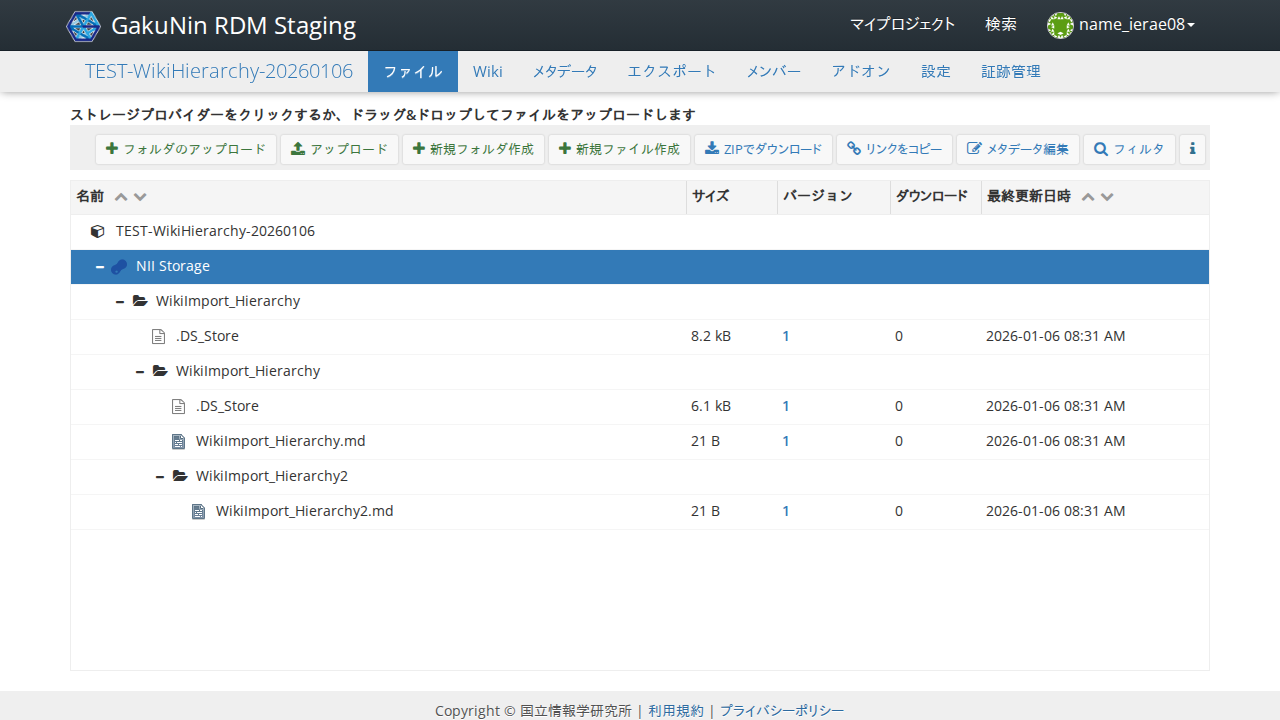

In [12]:
async def _step(page):
    await page.locator('//a[text() = "Done"]').click()
    await expect(page.locator('text="ステータスをアップロード"')).not_to_be_visible(timeout=transition_timeout)
    await expect(grdm.get_select_folder_title_locator(page, foldername).first).to_be_visible(timeout=transition_timeout)

await run_pw(_step)

## Wikiタブをクリックする

画面がWikiに切り替わること

Start epoch: 1767688297.102816 seconds


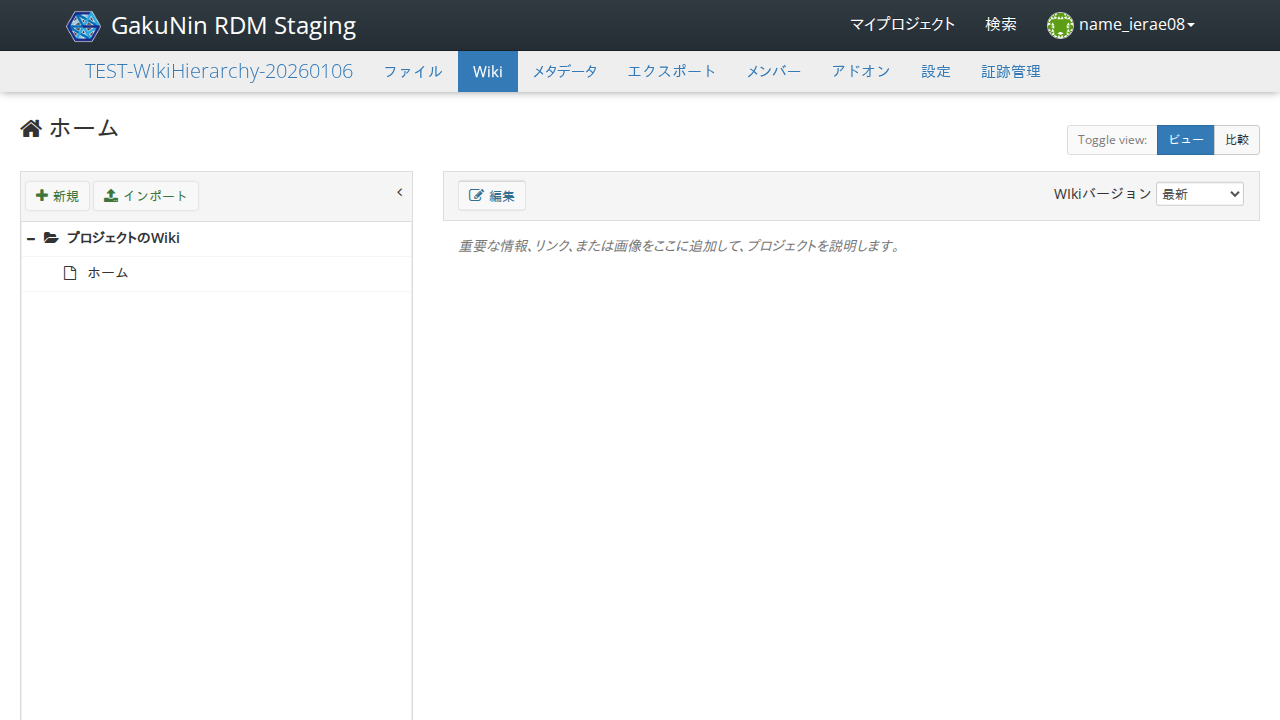

In [13]:
async def _step(page):
    await page.get_by_role("link", name="Wiki", exact=True).click()
    await expect(page.locator('//*[contains(@class, "title-text")]//*[text() = "プロジェクトのWiki"]')).to_be_visible(timeout=transition_timeout)

await run_pw(_step)

## 「インポート」ボタンをクリックする

「Wikiページをインポートする」画面が表示されること

Start epoch: 1767688300.5194273 seconds


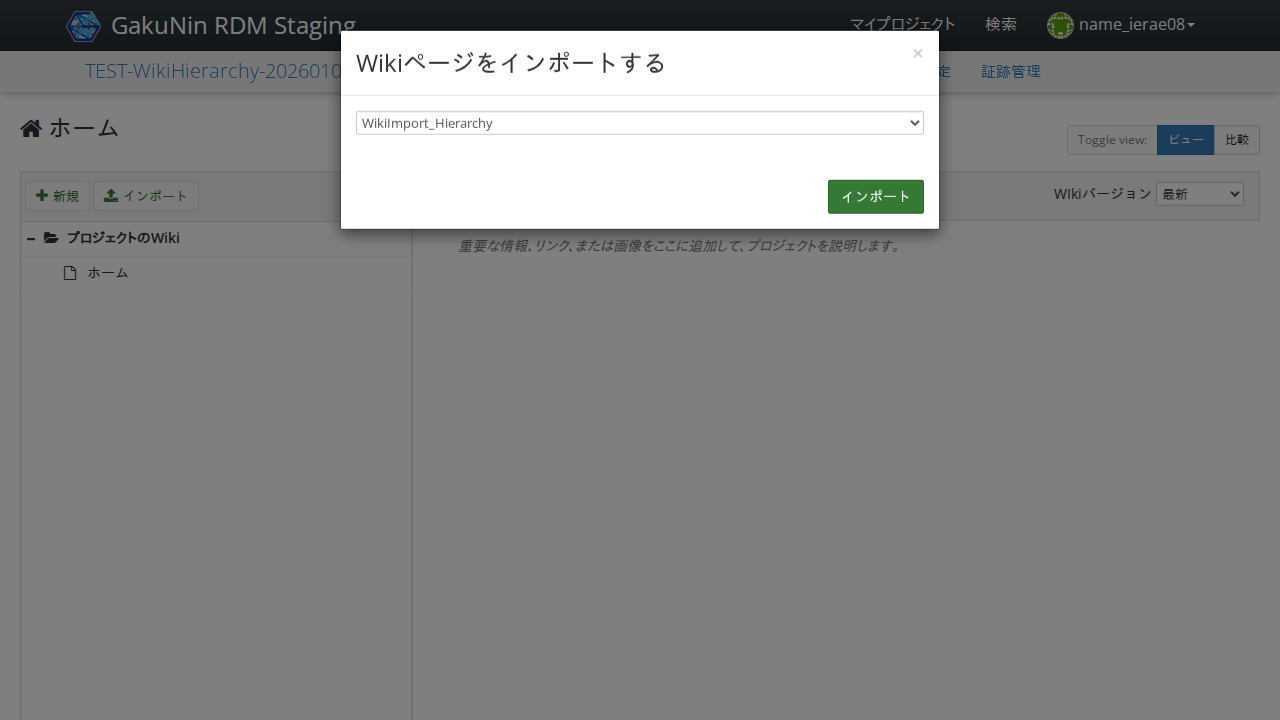

In [14]:
async def _step(page):
    await page.locator('div[data-target="#wikiImport"]').click()
    await expect(page.locator('h3.modal-title', has_text="Wikiページをインポートする")).to_be_visible(timeout=transition_timeout)

await run_pw(_step)

## リストボックスで「WikiImport_Hierarchy」を選択し「インポート」ボタンをクリックする

- ボタンが「Wikiページを検証中」→「インポート中」となること
- インポートが完了すると「Import Complete」と表示されること

Start epoch: 1767688301.2831886 seconds


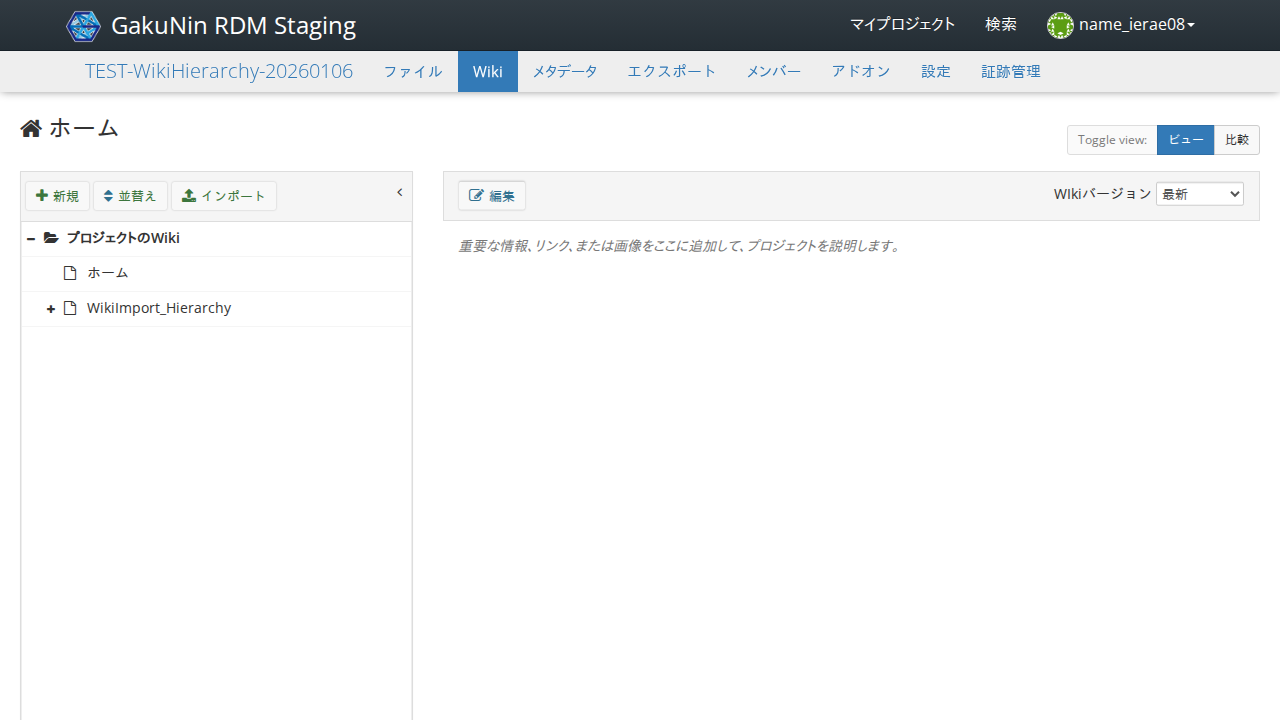

In [15]:
async def _step(page):
    await page.select_option('#wikiImportDir', label=f"{foldername}")
    await grdm.click_and_expect_alert(page, lambda: page.locator('//button[text()="インポート"]').click(), "Import Complete")

await run_pw(_step)

## 「Import Complete」と表示された画面にて「OK」ボタンをクリックする

- Wikiの画面に戻り、インポートされたファイルが、画面左の「プロジェクトのWiki」配下に「WikiImport_Hierarchy」が表示されること
- 「WikiImport_Hierarchy」フォルダが階層化されていること

Start epoch: 1767688315.8346486 seconds


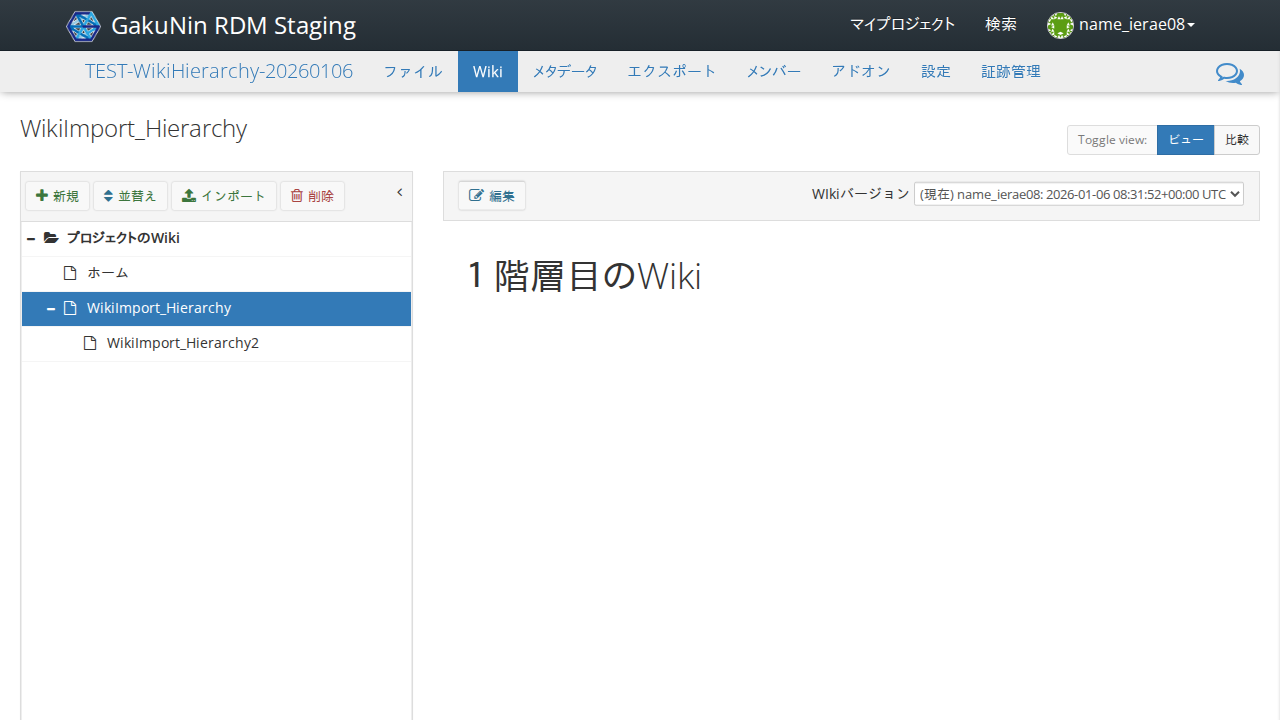

In [16]:
async def _step(page):
    await expect(page.locator(f'//*[contains(@class, "title-text")]//*[text() = "{foldername}"]')).to_be_visible(timeout=transition_timeout)
    await page.locator(f'//*[contains(@class, "title-text")]//*[text() = "{foldername}"]').click()
    await page.locator('//div[contains(@class, "fangorn-selected")]//i[contains(@class, "fa-plus")]').click()
    await expect(page.locator('//*[contains(@class, "title-text")]//*[text() = "WikiImport_Hierarchy2"]')).to_be_visible(timeout=transition_timeout)

await run_pw(_step)

## 画面左の「プロジェクトのWiki」から任意のWikiを選択し「新規」ボタンをクリックする

新規Wikiページを追加画面が表示されること

Start epoch: 1767688317.8368042 seconds


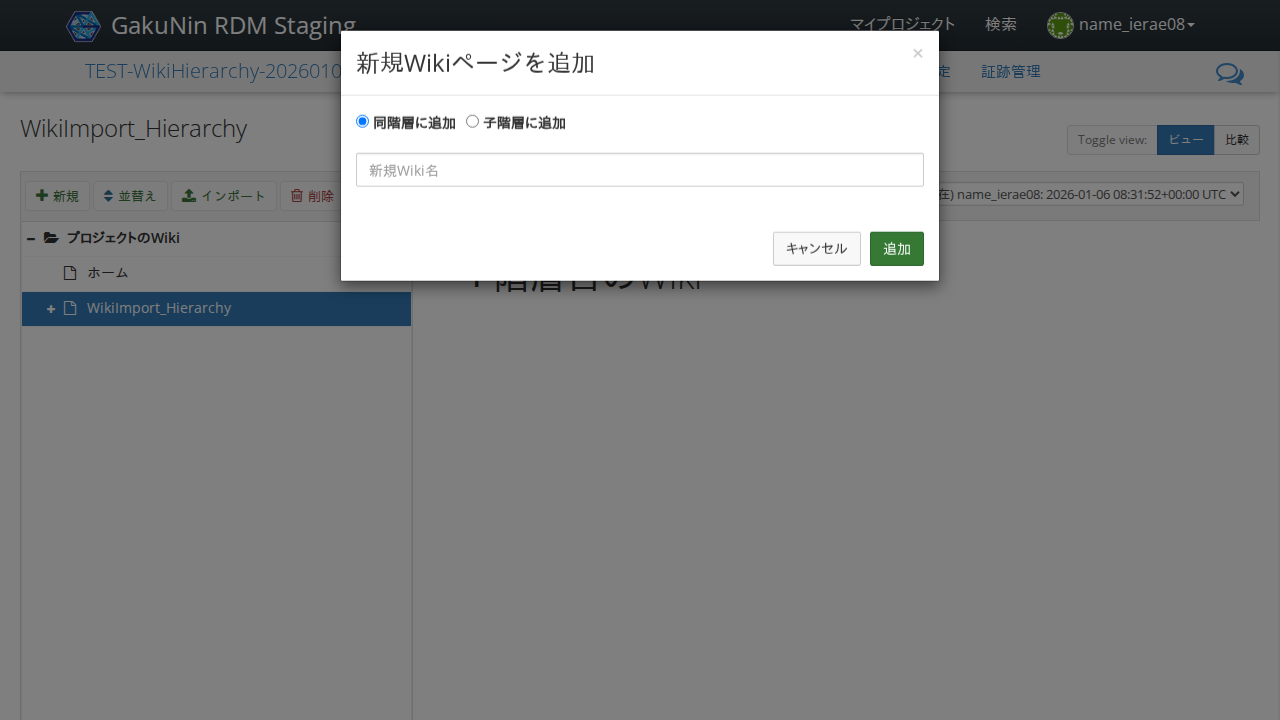

In [17]:
async def _step(page):
    await page.locator(f'//*[contains(@class, "title-text")]//*[text() = "{foldername}"]').click()
    await expect(page.locator(f'//*[contains(@class, "title-text")]//*[text() = "{foldername}"]')).to_be_visible(timeout=transition_timeout)
    await page.locator('div[data-target="#newWiki"]').click() 
    await expect(page.locator('h3.modal-title', has_text="新規Wikiページを追加")).to_be_visible(timeout=transition_timeout)

await run_pw(_step)

## 「子階層に追加」を選択し、任意の新規Wiki名を入力後、「追加」ボタンをクリックする

選択したWikiページの子階層に、作成したWikiページが表示されること

Start epoch: 1767688320.458988 seconds


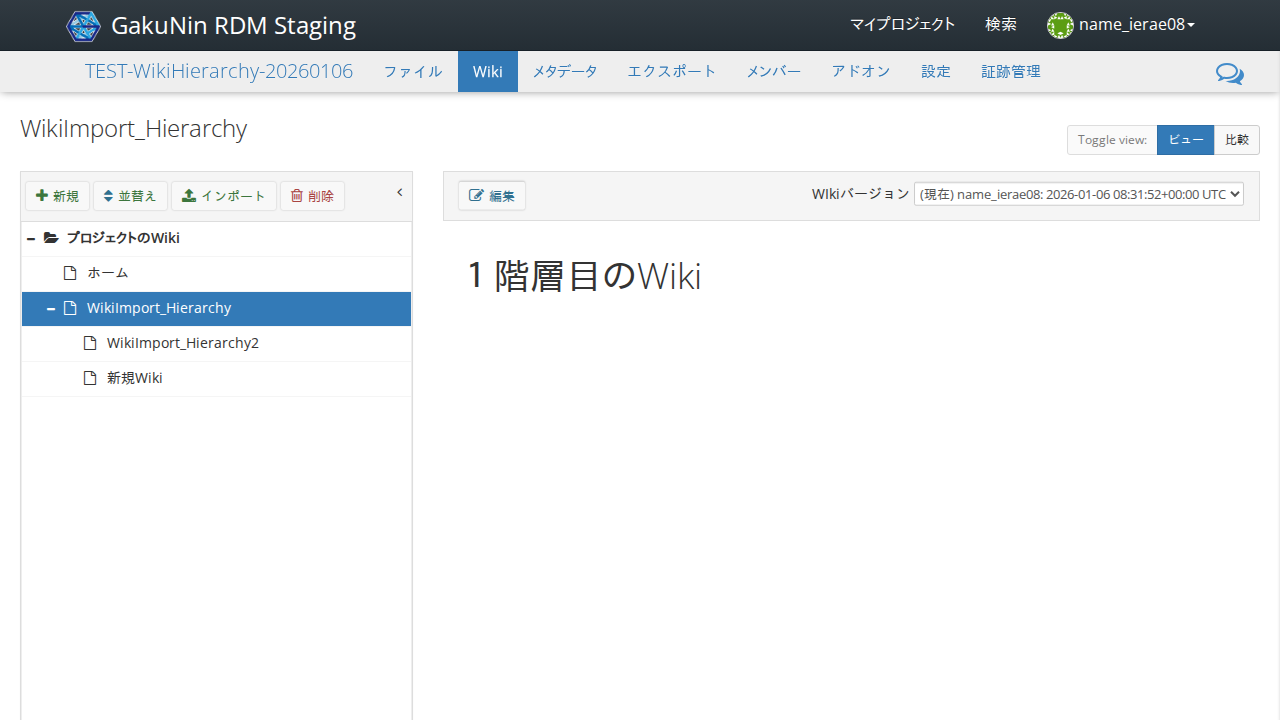

In [18]:
new_wikiname = '新規Wiki'
async def _step(page):
    await page.locator('input[name="addHierarchy"][value="false"]').check()
    await page.fill('#data', new_wikiname)
    await page.locator('#add-wiki-submit').click()
    await expect(page.locator(f'//*[contains(@class, "title-text")]//*[text() = "{foldername}"]')).to_be_visible(timeout=transition_timeout)
    await page.locator(f'//*[contains(@class, "title-text")]//*[text() = "{foldername}"]').click()
    await page.locator('//div[contains(@class, "fangorn-selected")]//i[contains(@class, "fa-plus")]').click()
    await expect(page.locator(f'//*[contains(@class, "title-text")]//*[text() = "{new_wikiname}"]')).to_be_visible(timeout=transition_timeout)

await run_pw(_step)

## 画面左の「プロジェクトのWiki」内にある「並替え」をクリックする

Wikiツリー並び替え画面が表示されること

Start epoch: 1767688325.4522784 seconds


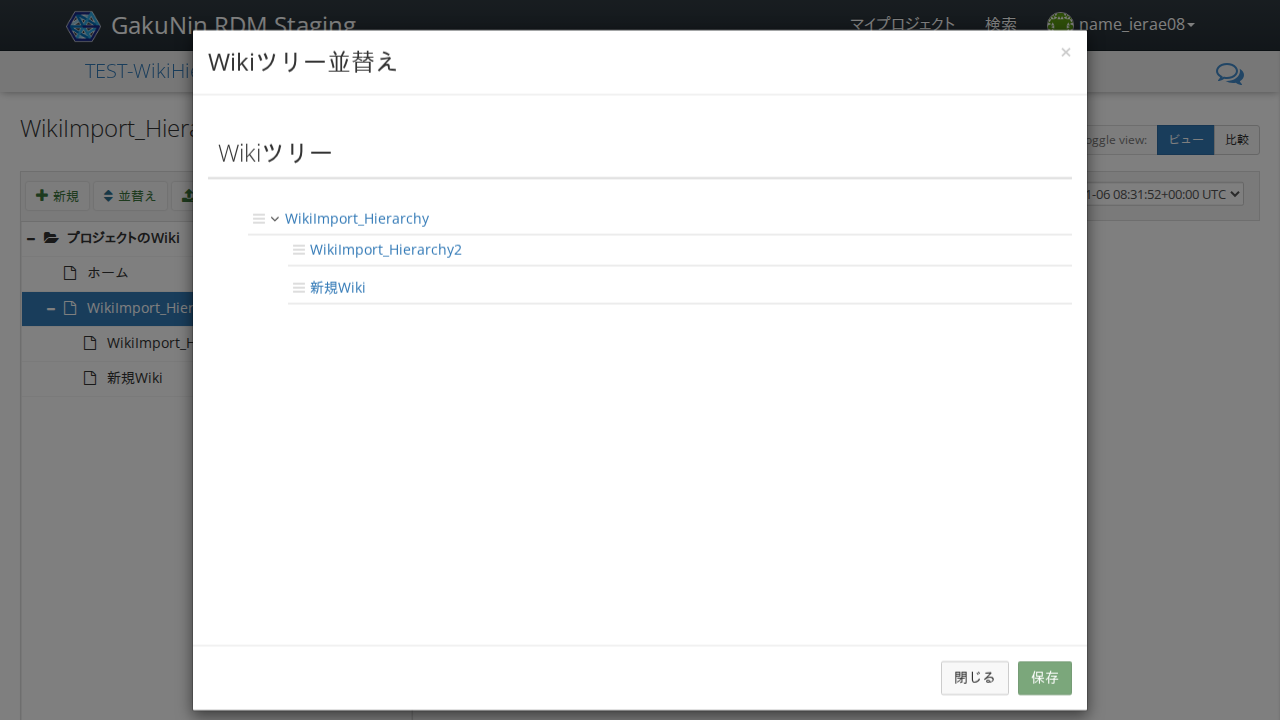

In [19]:
async def _step(page):
    await page.locator('div[data-target="#sortWiki"]').click() 
    await expect(page.locator('h3.modal-title', has_text="Wikiツリー並替え")).to_be_visible(timeout=transition_timeout)
    await expect(page.locator(f'.sort-item:has-text("{new_wikiname}") .sort-bars').first).to_be_visible(timeout=transition_timeout)

await run_pw(_step)

## 任意のWikiページを選択し、他のWikiへドラックアンドドロップで移動させる

ツリー表示が階層化されること

Start epoch: 1767688326.2425666 seconds


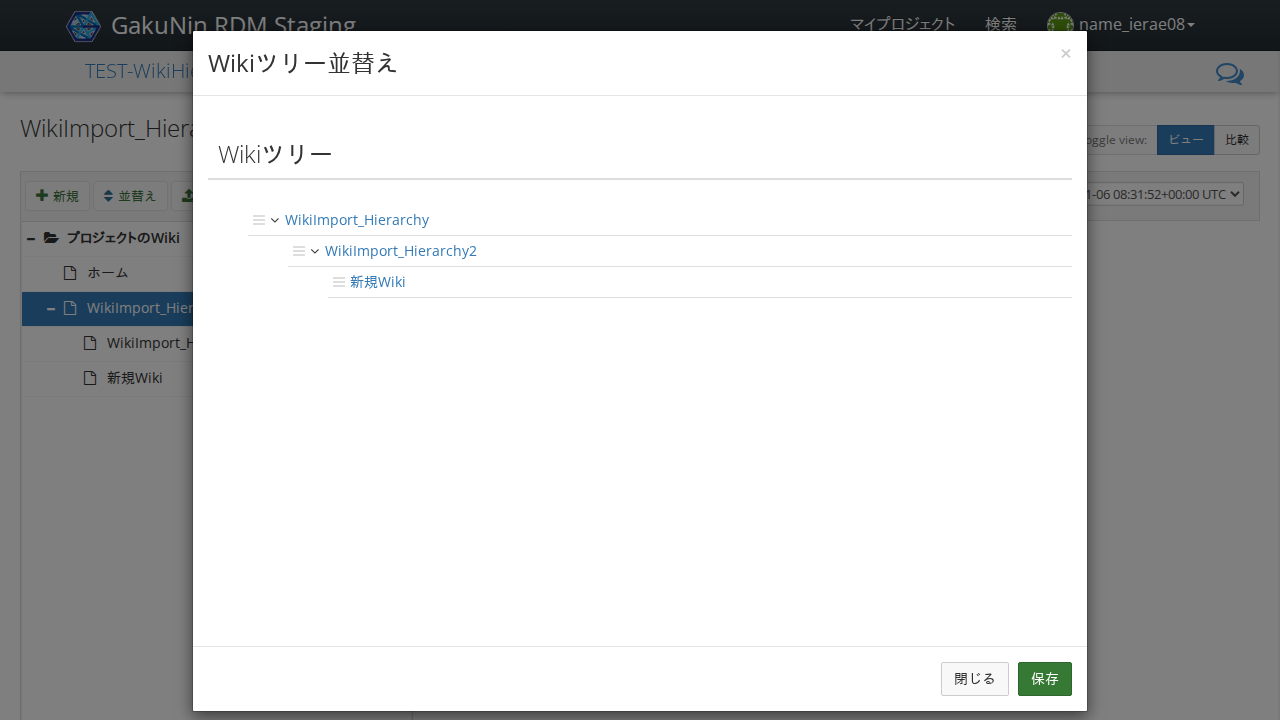

In [20]:
async def _step(page):
    source = page.locator('.sort-item:has-text("新規Wiki") .sort-bars').first
    target_ul = page.locator('.sort-item:has-text("WikiImport_Hierarchy2")' ).first.locator('xpath=ancestor::li[1]/ul[contains(@class,"sort-children")]')

    src = await source.bounding_box()
    tgt = await target_ul.bounding_box()
    if not src or not tgt:
        raise Exception("Bounding box missing")

    src_x = src["x"] + src["width"] / 2
    src_y = src["y"] + src["height"] / 2
    tgt_x = tgt["x"] + tgt["width"] / 2
    tgt_y = tgt["y"] + tgt["height"] / 2

    await page.mouse.move(src_x, src_y)
    await page.mouse.down()
    await page.wait_for_timeout(200)

    steps = 30
    for i in range(steps):
        await page.mouse.move(
            src_x + (tgt_x - src_x) * (i + 1) / steps,
            src_y + (tgt_y - src_y) * (i + 1) / steps,
        )
        await page.wait_for_timeout(40)

    await page.wait_for_timeout(300)
    await page.mouse.up()

await run_pw(_step)

## Wikiツリー並び替え画面で「保存」ボタンをクリックする

Wikiツリー並び替え画面が消え、画面左のプロジェクトのWikiが階層化されて表示されること

Start epoch: 1767688329.0529652 seconds


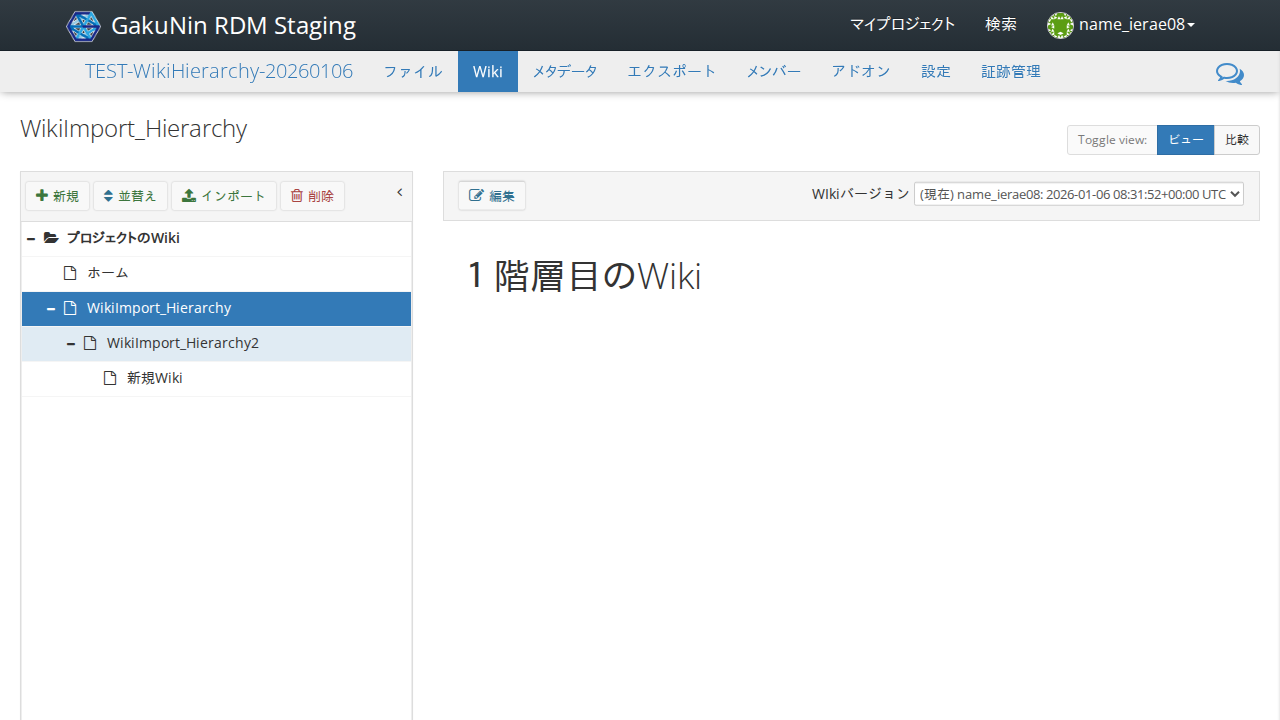

In [21]:
async def _step(page):
    await page.locator('#treeSave').click()
    await expect(page.locator('//*[contains(@class, "title-text")]//*[text() = "WikiImport_Hierarchy"]')).to_be_visible(timeout=transition_timeout)
    await page.locator('//*[contains(@class,"title-text")]//a[text()="WikiImport_Hierarchy"]/../../span[@class="tb-td-first"]/span[@class="tb-toggle-icon"]/i[contains(@class,"fa-plus")]'). click()
    await expect(page.locator('//*[contains(@class, "title-text")]//*[text() = "WikiImport_Hierarchy2"]')).to_be_visible(timeout=transition_timeout)
    await page.locator('//*[contains(@class,"title-text")]//a[text()="WikiImport_Hierarchy2"]/../../span[@class="tb-td-first"]/span[@class="tb-toggle-icon"]/i[contains(@class,"fa-plus")]'). click()
    await expect(page.locator(f'//*[contains(@class, "title-text")]//*[text() = "{new_wikiname}"]')).to_be_visible(timeout=transition_timeout)

await run_pw(_step)

## 画面左の「プロジェクトのWiki」内にあるツリー構造となっているWikiにて、末端の階層に存在するWikiをクリックする

Wikiの内容が表示されること

Start epoch: 1767688331.0774438 seconds


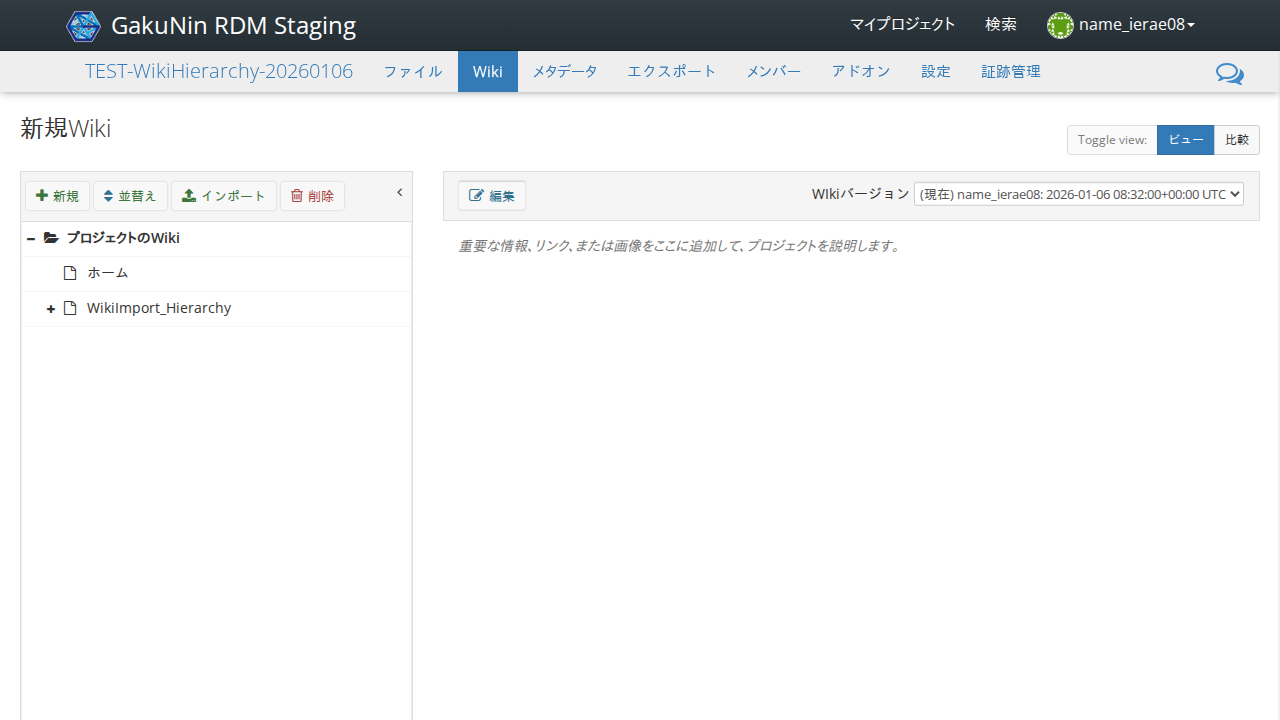

In [22]:
async def _step(page):
    await grdm.open_wiki(page, new_wikiname, '重要な情報、リンク、または画像をここに追加して、プロジェクトを説明します。')

await run_pw(_step)

## 「削除」ボタンをクリックする

Wikiページを削除する確認画面が表示される

Start epoch: 1767688333.1997502 seconds


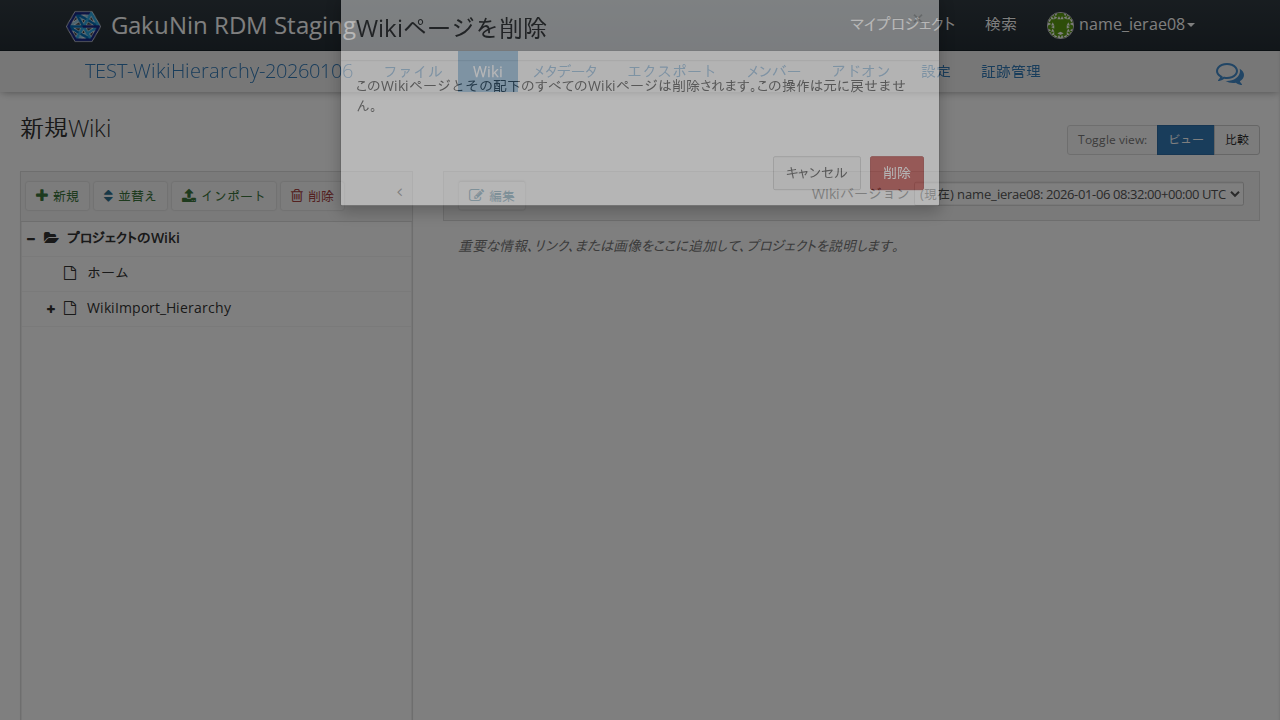

In [23]:
import re
async def _step(page):
    await page.locator('div[data-target="#deleteWiki"]').click()
    await expect(page.locator('h3.modal-title', has_text=re.compile(r"^Wikiページを削除$"))).to_be_visible(timeout=transition_timeout)

await run_pw(_step)

## 「削除」ボタンをクリックする

Wikiページが再表示され、先ほど選択していたWikiが削除されていること

Start epoch: 1767688333.792646 seconds


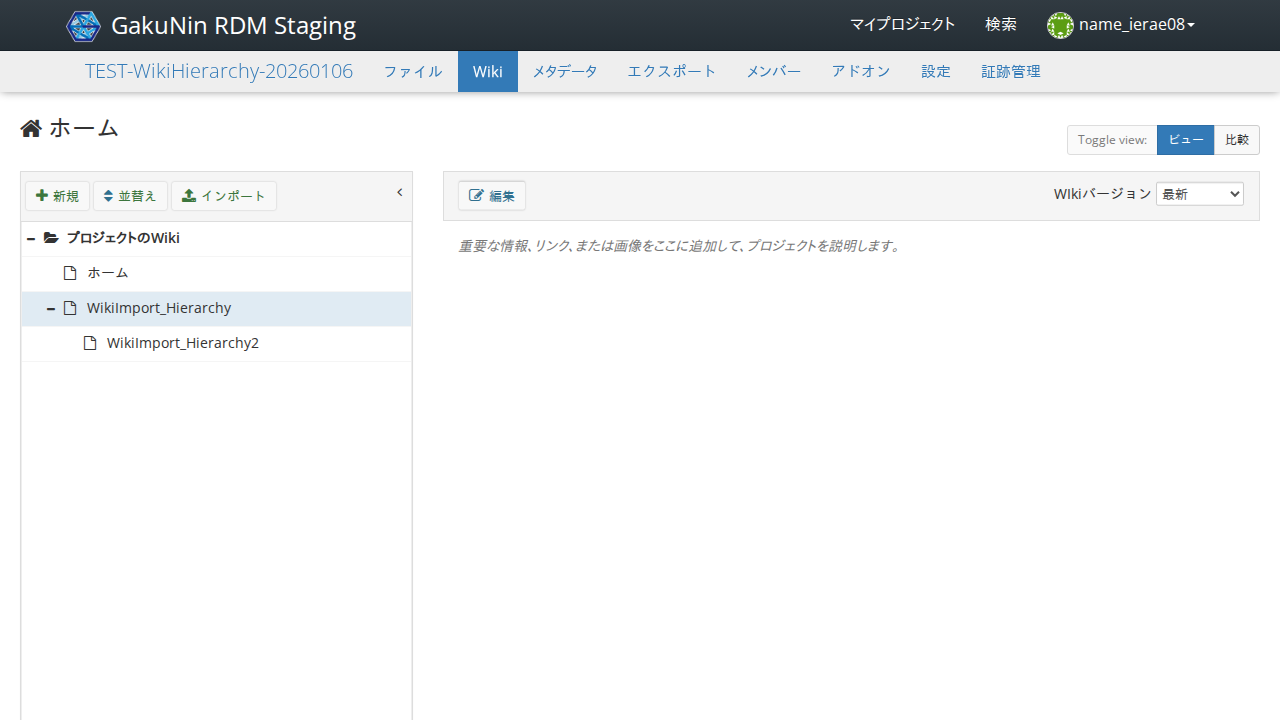

In [24]:
async def _step(page):
    await page.locator('#delete-wiki').click()
    await expect(page.locator('h3.modal-title', has_text=re.compile(r"^Wikiページを削除$"))).not_to_be_visible(timeout=transition_timeout)
    await expect(page.locator('//*[contains(@class, "title-text")]//*[text() = "WikiImport_Hierarchy"]')).to_be_visible(timeout=transition_timeout)
    await page.locator('//*[contains(@class,"title-text")]//a[text()="WikiImport_Hierarchy"]/../../span[@class="tb-td-first"]/span[@class="tb-toggle-icon"]/i[contains(@class,"fa-plus")]'). click()
    await expect(page.locator('//*[contains(@class, "title-text")]//*[text() = "WikiImport_Hierarchy2"]')).to_be_visible(timeout=transition_timeout)
    await expect(page.locator(f'//*[contains(@class, "title-text")]//*[text() = "{new_wikiname}"]')).not_to_be_visible(timeout=transition_timeout)

await run_pw(_step)

## 画面左のプロジェクトのWiki内にあるツリー構造となっているWikiにて、中間の階層に存在するWikiをクリックする

Wikiの内容が表示されること

Start epoch: 1767688336.2489154 seconds


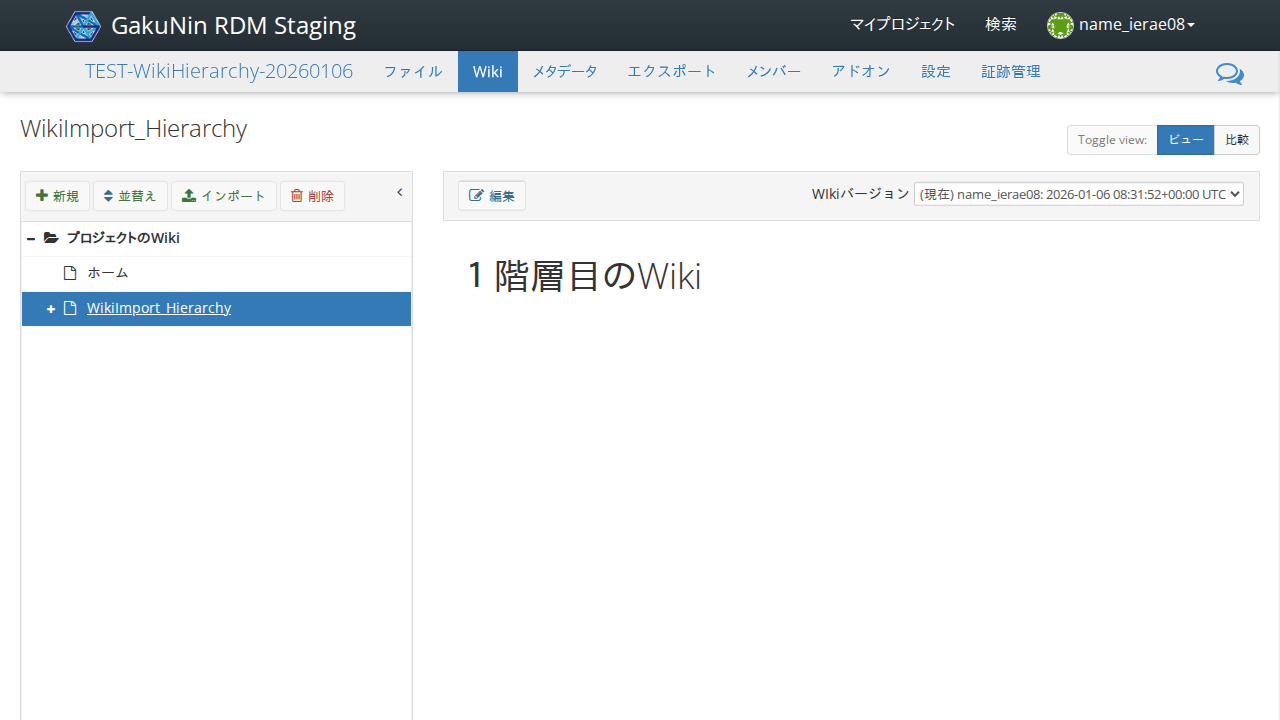

In [25]:
async def _step(page):
    await grdm.open_wiki(page, 'WikiImport_Hierarchy', '１階層目のWiki')

await run_pw(_step)

## 「削除」ボタンをクリックする

Wikiページを削除する確認画面が表示される

Start epoch: 1767688338.2344065 seconds


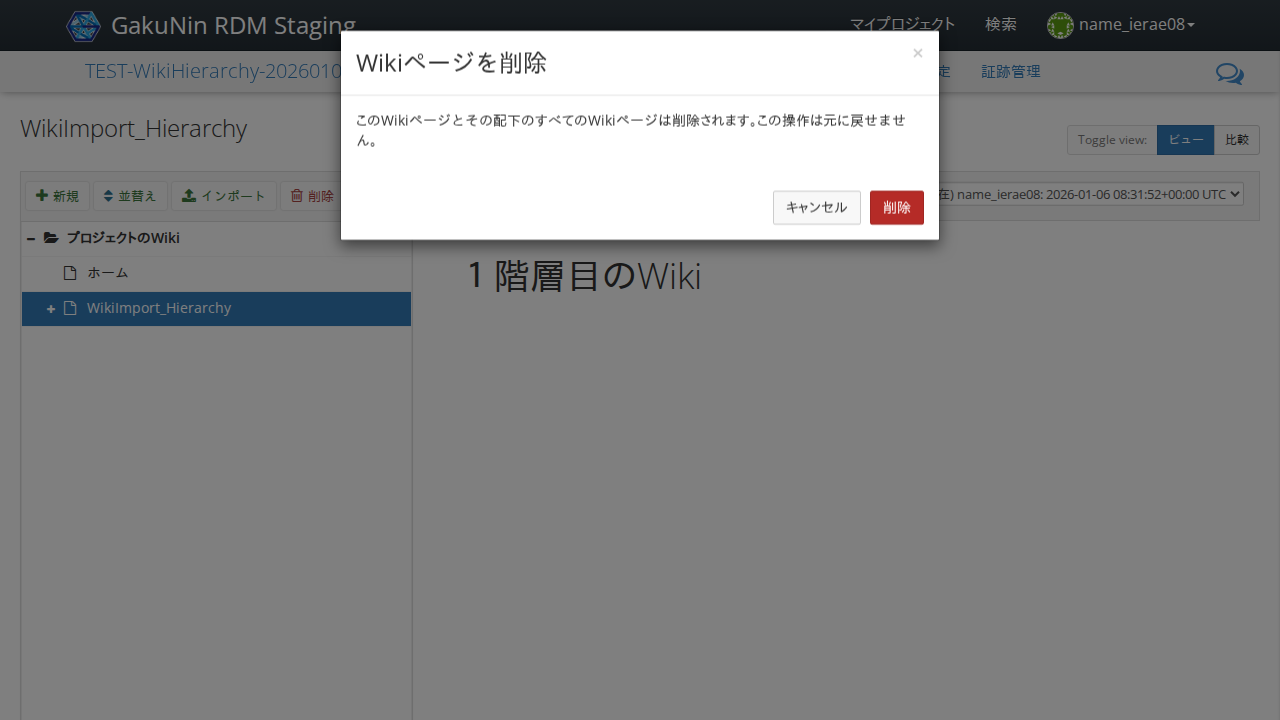

In [26]:
async def _step(page):
    await page.locator('div[data-target="#deleteWiki"]').click()
    await expect(page.locator('h3.modal-title', has_text=re.compile(r"^Wikiページを削除$"))).to_be_visible(timeout=transition_timeout)

await run_pw(_step)

## 「削除」ボタンをクリックする

選択していたWikiおよび、その下の階層が全て削除されること

Start epoch: 1767688339.051954 seconds


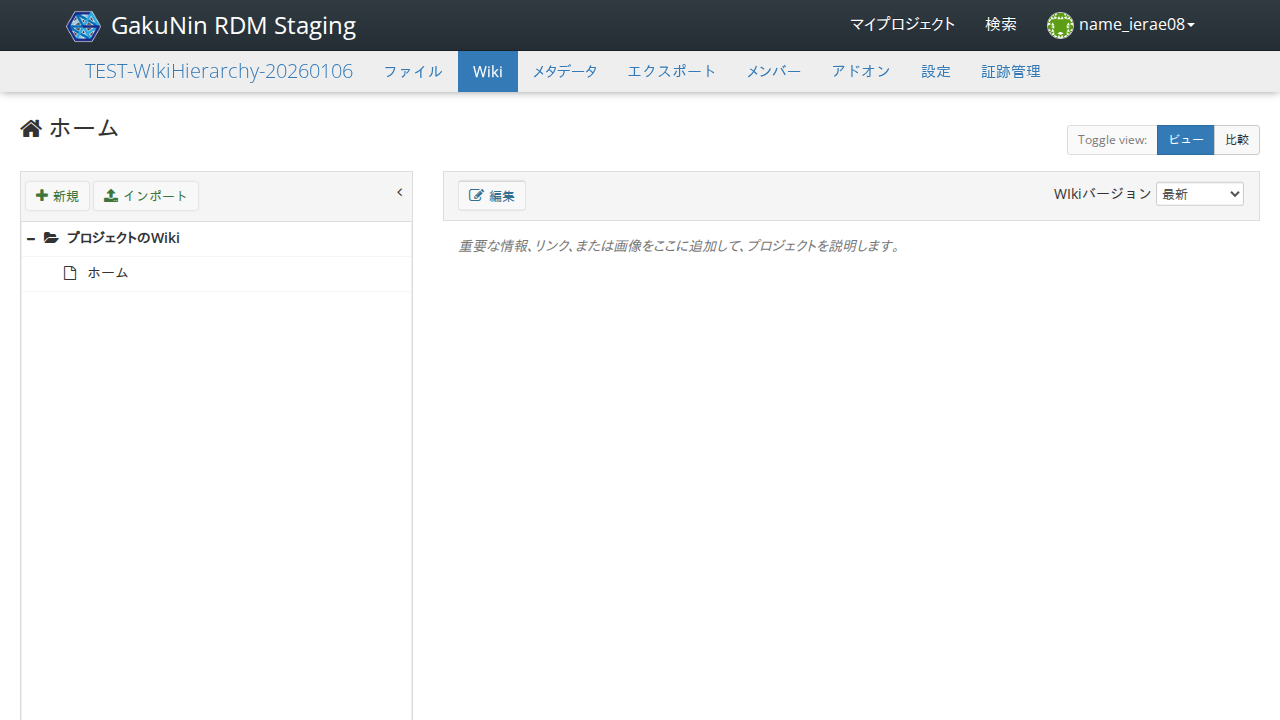

In [27]:
async def _step(page):
    await page.locator('#delete-wiki').click()
    await expect(page.locator('h3.modal-title', has_text=re.compile(r"^Wikiページを削除$"))).not_to_be_visible(timeout=transition_timeout)
    await expect(page.locator('//*[contains(@class, "title-text")]//*[text() = "プロジェクトのWiki"]')).to_be_visible(timeout=transition_timeout)
    await expect(page.locator('//*[contains(@class, "title-text")]//*[text() = "WikiImport_Hierarchy"]')).not_to_be_visible(timeout=transition_timeout)

await run_pw(_step)

## (指定がある場合) プロジェクトを削除する

Start epoch: 1767688341.281316 seconds


Carver


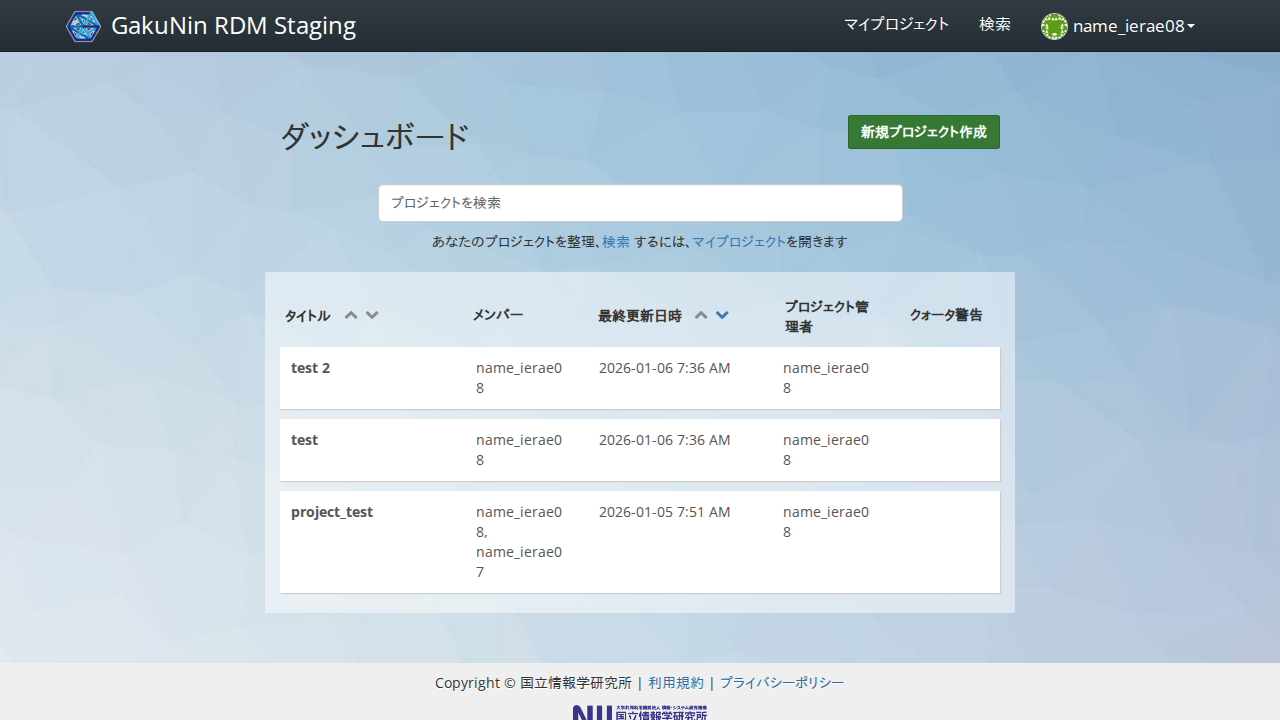

In [28]:
async def _step(page):
    if not delete_project:
        return
    await scripts.grdm.delete_project(page)
    await scripts.grdm.expect_dashboard(page, transition_timeout=transition_timeout)

await run_pw(_step)

終了処理を実施。

In [ ]:
await finish_pw_context()

In [30]:
!rm -fr {work_dir}